# High-Dimensional Time Series Forecasting with Convolutional Neural Networks: Adding Exogenous Features to WaveNet

**Note**: for a written overview on this topic, check out my blog post (coming soon!!). 

This notebook builds on the [previous notebook in this series](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Full.ipynb), where I demonstrated in python/keras code how a **convolutional** sequence-to-sequence neural network modeled after WaveNet can be built for the purpose of high-dimensional time series forecasting. I assume that you're comfortable with the core model and set out to improve it by adding **exogenous features** to the model's input on top of the raw time series signals. In forecasting, exogenous features are those external to the forecasted series that may have a causal influence on it (e.g. day of the week or language of a wikipedia page). They often provide predictive signal that's not fully captured by historical values of the target series alone. Here we'll see how these features can be derived and properly formatted in a keras setting along with how our network architecture can be modified to handle them.   

We'll be using the same daily wikipedia web page traffic dataset, available [here on Kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data). And once again with our full-fledged model we'll forecast 60 days into the future, using all of the series history available in "train_1.csv" for the encoding stage of the model. 

Our workflow's structure is mostly unchanged from the previous notebook, but adds a new section on exogenous feature extraction. The features we'll extract are day of the week and page-specific metadata (language, access type, and agent type). The model formatting and building sections are also modified to accomodate the inclusion of these features. Feel free to focus on those sections (2-6) if you're comfortable with the setup steps (as in the previous notebooks).     

Here's a section breakdown of this notebook -- enjoy!

**1. Loading and Previewing the Data**   
**2. Exogenous Feature Engineering**   
**3. Formatting the Data for Modeling**  
**4. Building the Model - Training Architecture**  
**5. Building the Model - Inference Loop**  
**6. Generating and Plotting Predictions**

## 1. Loading and Previewing the Data 

First thing's first, let's load up the data and get a quick feel for it (reminder that the dataset is available [here](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data)). 

Note that there are a good number of NaN values in the data that don't disambiguate missing from zero. For the sake of simplicity in this tutorial, we'll naively fill these with 0 later on.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

df = pd.read_csv('../data/train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [3]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2016-12-31


We can define a function that lets us visualize some random webpage series as below. For the sake of smoothing out the scale of traffic across different series, we apply a log1p transformation before plotting - i.e. take $\log(1+x)$ for each value $x$ in a series.

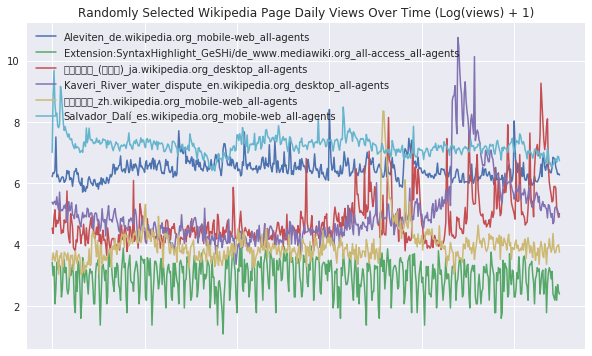

In [4]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    page_labels = sample['Page'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time (Log(views) + 1)')
    plt.legend(page_labels)
    
plot_random_series(df, 6)

## 2. Exogenous Feature Engineering

Glancing back at our preview of the data above, we see that we have information that isn't directly captured by the raw traffic time series. The **page column** gives us metadata on each series that might guide our model in identifying shared patterns across related series. For example, pages written in the same language may exhibit similar seasonality patterns. Similarly, the **date column headers** let us explicitly encode day of the week information as a way of anchoring the model's understanding of weekly seasonality. In the code to follow, we'll extract numeric features from both of these sources and wrangle them into a format that keras will cleanly accept as input when combined with the raw series.



![architecture](images/Page_exog.png)



Let's start by converting dates to **one-hot-encoded** / **dummy variable** representations of day of the week, following the standard approach for handling categorical features. It's simple to do this using pandas:  

In [5]:
dow_ohe = pd.get_dummies(pd.to_datetime(df.columns[1:]).dayofweek)
dow_ohe.head(8)

,0,1,2,3,4,5,6
0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1
5,1,0,0,0,0,0,0
6,0,1,0,0,0,0,0
7,0,0,1,0,0,0,0


Right now we have a dataframe of shape (n_timesteps, 7), with binary columns corresponding to each day of the week. We need to do a bit more for keras-friendly formatting: when processing a sequence of features, keras expects input arrays (tensors) of shape **(n_samples, n_timesteps, n_features)**. In this case, the day of week features are shared across all of the individual page series (our samples), so we want to just repeat the one-hot-encoded data n_samples (~145,000) times to get the 3-dimensional array we need. We can accomplish this using the handy numpy functions **expand_dims** and **tile** as below.

In [6]:
dow_array = np.expand_dims(dow_ohe.values, axis=0) # add sample dimension
dow_array = np.tile(dow_array,(df.shape[0],1,1)) # repeat OHE array along sample dimension
dow_array.shape

(145063, 550, 7)

Great, that's the exact format we need for an input array; now we'll just add the **page metadata** to this array. Let's take a quick look at the raw format of that metadata:

In [7]:
df['Page'].head(8)

0              2NE1_zh.wikipedia.org_all-access_spider
1               2PM_zh.wikipedia.org_all-access_spider
2                3C_zh.wikipedia.org_all-access_spider
3           4minute_zh.wikipedia.org_all-access_spider
4    52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...
5              5566_zh.wikipedia.org_all-access_spider
6            91Days_zh.wikipedia.org_all-access_spider
7             A'N'D_zh.wikipedia.org_all-access_spider
Name: Page, dtype: object

It turns out that this data is underscore delimited as **name_project_access_agent**. We should split that out into distinct columns, with the one tricky part being that underscores can occur in the _name_ field that would throw off a simple split on underscore. A quick workaround is to use the **rsplit** function to work from right to left and limit the number of splits to 3. 

In [8]:
page_df = df['Page'].str.rsplit('_', n=3, expand=True) # split page string and expand to multiple columns 
page_df.columns = ['name','project','access','agent']
page_df.head()

,name,project,access,agent
0,2NE1,zh.wikipedia.org,all-access,spider
1,2PM,zh.wikipedia.org,all-access,spider
2,3C,zh.wikipedia.org,all-access,spider
3,4minute,zh.wikipedia.org,all-access,spider
4,52_Hz_I_Love_You,zh.wikipedia.org,all-access,spider


That looks great, so let's do a quick cardinality check on each of these categorical variables before we one-hot-encode them like we did for day of the week.

In [9]:
page_df.nunique()

name       49174
project        9
access         3
agent          2
dtype: int64

Since there are so many different names, it's likely more trouble than it's worth to include name in our feature set (it would mean an increase of ~50000 features in our input array!). So we'll drop name and one-hot-encode the low cardinality features to get a dataframe of shape (n_samples, n_features). Then we can repeat these features along the timesteps dimension to get the needed 3-dimensional array.      

In [10]:
page_df = page_df.drop('name', axis=1)

page_array = pd.get_dummies(page_df).values
page_array = np.expand_dims(page_array, axis=1) # add timesteps dimension
page_array = np.tile(page_array,(1,dow_array.shape[1],1)) # repeat OHE array along timesteps dimension 
page_array.shape

(145063, 550, 14)

The final step to complete our exogenous feature array is simply to concatenate the day of week information and page metadata into one shared array.

In [11]:
exog_array = np.concatenate([dow_array, page_array], axis=-1)
exog_array.shape

(145063, 550, 21)

That's it, our exogenous feature extraction is all done! In the next section we'll write a function that lets us combine this exogenous feature array with the endogenous time series data in order to prepare for model training and prediction.   

## 3. Formatting the Data for Modeling 

Sadly we can't just throw the time series dataframe and exogenous array we've created into keras and let it work its magic. Instead, we have to set up a few more data transformation steps to extract the exact numpy arrays that we'll later pass to keras. But even before doing that, we have to know how to appropriately partition the time series into encoding and prediction intervals for the purposes of training and validation. Note that for our simple convolutional model we won't use an encoder-decoder architecture like in the first notebook in this repo, but **we'll keep the "encoding" and "decoding" (prediction) terminology to be consistent** -- in this case, the encoding interval represents the entire series history that we will use for the network's feature learning, but not output any predictions on. 

We'll use a style of **walk-forward validation**, where our validation set spans the same time-range as our training set, but shifted forward in time (in this case by 60 days). This way, we simulate how our model will perform on unseen data that comes in the future. 

[Artur Suilin](https://github.com/Arturus/kaggle-web-traffic/blob/master/how_it_works.md) has created a very nice image that visualizes this validation style and contrasts it with traditional validation. I highly recommend checking out his entire repo, as he's implemented a truly state of the art (and competition winning) seq2seq model on this data set. 

![architecture](images/ArturSuilin_validation.png)

### Train and Validation Series Partioning

We need to create 4 sub-segments of the data:

    1. Train encoding period
    2. Train decoding period (train targets, 60 days)
    3. Validation encoding period
    4. Validation decoding period (validation targets, 60 days)
    
We'll do this by finding the appropriate start and end dates for each segment. Starting from the end of the data we've loaded, we'll work backwards to get validation and training prediction intervals. Then we'll work forward from the start to get training and validation encoding intervals. 

In [12]:
from datetime import timedelta

pred_steps = 60 
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1) 

In [13]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

In [14]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-07-01 00:00:00 - 2016-09-02 00:00:00
Train prediction: 2016-09-03 00:00:00 - 2016-11-01 00:00:00 

Val encoding: 2015-08-30 00:00:00 - 2016-11-01 00:00:00
Val prediction: 2016-11-02 00:00:00 - 2016-12-31 00:00:00

Encoding interval: 430
Prediction interval: 60


### Keras Data Formatting

Now that we have the time segment dates, we'll define the functions we need to extract the data in keras friendly format. Here are the steps:

* Pull the time series into an array, save a date_to_index mapping as a utility for referencing into the array 
* Create function to extract specified time interval from all the series 
* Create functions to transform all the series. 
    - Here we smooth out the scale by taking log1p and de-meaning each series using the encoder series mean, then reshape to the **(n_series, n_timesteps, n_features) tensor format** that keras will expect. 
    - Note that if we want to generate true predictions instead of log scale ones, we can easily apply a reverse transformation at prediction time. 
* Create final function to extract complete encoding and target arrays, leveraging prior functions 
    - This will act as a one-shot function that grabs what we need to train or predict
    - It will extract (transformed) endogenous series data and combine it with our exogenous features

The first code block below accomplishes the first 3 steps, unchanged from the earlier notebooks in this series.

In [15]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

Now we can leverage the first 3 processing steps built out above in order to create a one-shot preprocessing function for extracting encoder/input data (with the correct exogenous features attached) and decoder/target data. We'll include arguments that let us choose the number of time series samples to extract and which periods to sample from. With this function written, we'll be ready to set up the model!      

In [16]:
def get_data_encode_decode(series_array, exog_array, first_n_samples,
                           date_to_index, enc_start, enc_end, pred_start, pred_end):

    exog_inds = date_to_index[enc_start:pred_end]
    
    # sample of series from enc_start to enc_end  
    encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                               enc_start, enc_end)[:first_n_samples]
    encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
    
    # sample of series from pred_start to pred_end 
    decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                                pred_start, pred_end)[:first_n_samples]
    decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
    
    # we append a lagged history of the target series to the input data, 
    # so that we can train with teacher forcing
    lagged_target_history = decoder_target_data[:,:-1,:1]
    encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)
    
    # we add the exogenous features corresponding to day after input series
    # values to the input data (exog should match day we are predicting)
    exog_input_data = exog_array[:first_n_samples,exog_inds,:][:,1:,:]
    encoder_input_data = np.concatenate([encoder_input_data, exog_input_data], axis=-1)
    
    return encoder_input_data, decoder_target_data

## 4. Building the Model - Architecture

This convolutional architecture is a full-fledged version of the [WaveNet model](https://deepmind.com/blog/wavenet-generative-model-raw-audio/), designed as a generative model for audio (in particular, for text-to-speech applications). The wavenet model can be abstracted beyond audio to apply to any time series forecasting problem, providing a nice structure for capturing long-term dependencies without an excessive number of learned weights. Exogenous features can be integrated into WaveNet simply by extending the 3rd dimension (feature dimension) of the tensors that we feed to the model.

The core of the wavenet model can be described as a **stack of residual blocks** that utilize **dilated causal convolutions**, visualized by the two diagrams from the wavenet paper below. I've gone into detailed discussion of these model components in the two previous notebooks of this series ([part 1](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb), [part 2](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Full.ipynb)), so I'd recommend checking those out if you want to build familiarity.

![dilatedconv](images/WaveNet_dilatedconv.png)  

![blocks](images/WaveNet_residblock.png)        


### **Our Architecture**

With all of our components now laid out, here's what we'll use:

* 16 dilated causal convolutional blocks
    * Preprocessing and postprocessing (time distributed) fully connected layers (convolutions with filter width 1): 32 output units
    * 32 filters of width 2 per block
    * Exponentially increasing dilation rate with a reset (1, 2, 4, 8, ..., 128, 1, 2, ..., 128) 
    * Gated activations
    * Residual and skip connections
* 2 (time distributed) fully connected layers to map sum of skip outputs to final output 

Note that the only change in architecture from the previous notebook (without exogenous features) is an increase in units from 16 to 32 for the pre and postprocessing layers. This increase lets us better handle the larger number of input features (before we only used 1 feature!). 

As in the previous notebook, we'll extract the last 60 steps from the output sequence as our predicted output for training. We'll also use teacher forcing again during training, and write a separate function for iterative inference (section 5). 

In [17]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.FATAL) # suppress unhelpful tf warnings

from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam

# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
# Note the feature input dimension corresponds to the raw series and all exogenous features  
history_seq = Input(shape=(None, 1 + exog_array.shape[-1]))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(32, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(32, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':60})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

Using TensorFlow backend.


In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 22)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 32)     736         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 32)     2080        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, None, 32)     2080        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation

With our training architecture defined, we're ready to train the model! We'll leverage the transformer utility functions we defined earlier, and train using mean absolute error loss.

For this expansion of the full-fledged model, once again we end up more than doubling the total number of trainable parameters and incur the cost of slower training time. These additional parameters are due to the increase in filters for the pre/postprocessing layers. Training a model at this scale will take quite a while if you're not running fancy hardware - I'd recommend using a GPU. When constructing this notebook, I used an AWS EC2 instance with a GPU (p2.xlarge) and the Amazon Deep Learning AMI, and training took about an hour. 

This time around, we'll go ahead and use all of the series in the dataset for training, and train for 15 epochs to give this more complex model more time to try to reach its full potential. 

This is only a starting point, and I would encourage you to play around with this pipeline to see if you can get even better results! You could try selecting/engineering different exogenous features, adjusting the model architecture/hyperparameters, tuning the learning rate and number of epochs, etc.

In [19]:
first_n_samples = df.shape[0]
batch_size = 2**10 
epochs = 15

encoder_input_data, decoder_target_data = \
    get_data_encode_decode(series_array, exog_array, first_n_samples, date_to_index, 
                           train_enc_start, train_enc_end, train_pred_start, train_pred_end)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs)  

Epoch 1/15
145063/145063 [==============================] - 250s 2ms/step - loss: 0.3701
Epoch 2/15
145063/145063 [==============================] - 239s 2ms/step - loss: 0.2860
Epoch 3/15
145063/145063 [==============================] - 240s 2ms/step - loss: 0.2790
Epoch 4/15
145063/145063 [==============================] - 240s 2ms/step - loss: 0.2752
Epoch 5/15
145063/145063 [==============================] - 240s 2ms/step - loss: 0.2729
Epoch 6/15
145063/145063 [==============================] - 240s 2ms/step - loss: 0.2712
Epoch 7/15
145063/145063 [==============================] - 240s 2ms/step - loss: 0.2700
Epoch 8/15
145063/145063 [==============================] - 240s 2ms/step - loss: 0.2692
Epoch 9/15
145063/145063 [==============================] - 240s 2ms/step - loss: 0.2684
Epoch 10/15
145063/145063 [==============================] - 240s 2ms/step - loss: 0.2677
Epoch 11/15
145063/145063 [==============================] - 240s 2ms/step - loss: 0.2672
Epoch 12/15
145063/

## 5. Building the Model - Inference Loop

Like in the previous notebook, we'll generate predictions by running our model from section 3 in a loop, using each iteration to extract the prediction for the time step one beyond our current history then append it to our history sequence. In each iteration we'll also update the exogenous features to include values corresponding to the next time step we'll predict. With 60 iterations, this lets us generate predictions for the full interval we've chosen. 

Recall that we designed our model to output predictions for 60 time steps at once in order to use teacher forcing for training. So if we start from a history sequence and want to predict the first future time step, we can run the model on the history sequence and take the last time step of the output, which corresponds to one time step beyond the history sequence. 

In [26]:
def predict_sequence(input_tensor):

    history_tensor = input_tensor[:,:(-pred_steps+1),:]
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_tensor)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction along with corresponding exogenous features
        # to the history tensor
        last_step_exog = input_tensor[:,[(-pred_steps+1)+i],1:]
        last_step_tensor = np.concatenate([last_step_pred.reshape((1,1,1)), 
                                           last_step_exog], axis=-1)
        history_tensor = np.concatenate([history_tensor, last_step_tensor], axis=1)

    return pred_sequence

## 6. Generating and Plotting Predictions 

Now we have everything we need to generate predictions for encoder (history) /target series pairs that we didn't train on (note again we're using "encoder"/"decoder" terminology to stay consistent with notebook 1 -- here it's more like history/target). We'll pull out our set of validation encoder/target series (recall that these are shifted forward in time). Then using a plotting utility function which is updated to handle the addition of exogenous features in the input data, we can look at the tail end of the encoder series, the true target series, and the predicted target series. This gives us a feel for how our predictions are doing.  

In [27]:
encoder_input_data, decoder_target_data = \
    get_data_encode_decode(series_array, exog_array, df.shape[0], date_to_index, 
                           val_enc_start, val_enc_end, val_pred_start, val_pred_end)

In [28]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_tensor = encoder_input_data[[sample_ind],:,:] 
    pred_series = predict_sequence(encode_tensor)
    
    encode_series = encode_tensor[:,:(-pred_steps+1),0].reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

Generating some plots as below, we can see that our predictions are often strong and expressive, with similar performance to those generated by the full-fledged model without exogenous features. This suggests that the exogenous features we've added may not contribute additional predictive signal and reinforces the effectiveness of a purely endogenous model. It's possible that we haven't fully tapped into the exogenous features' potential and likely that other feature engineering techniques could help as well, but for now this would argue in favor of choosing a simpler, more efficient model over this significantly more complex one. Set out on your own to try to prove this conclusion wrong!  

One feature engineering trick that seems particularly promising is to hard-code certain long term seasonalities (i.e. quarterly or yearly) as additional features in the input sequences. I'd call this type of feature a **lagged endogenous feature** since it's derived from the actual time series. You can check out [Arthur Suilin's model description here](https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/43795) for his breakdown of this idea. I may explore this technique in a future notebook, so stay tuned!  

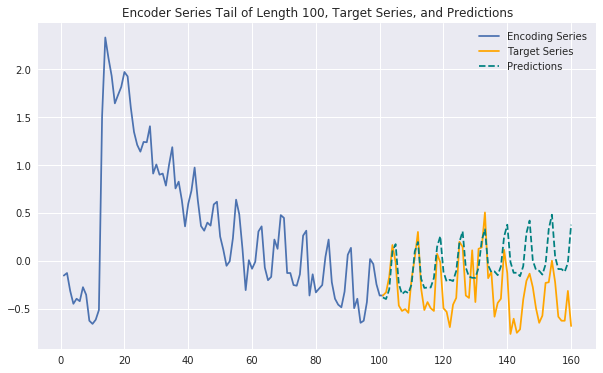

In [38]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=16534, enc_tail_len=100)

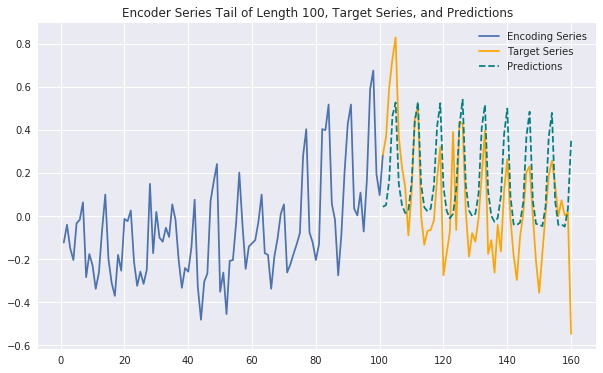

In [39]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=16555, enc_tail_len=100)

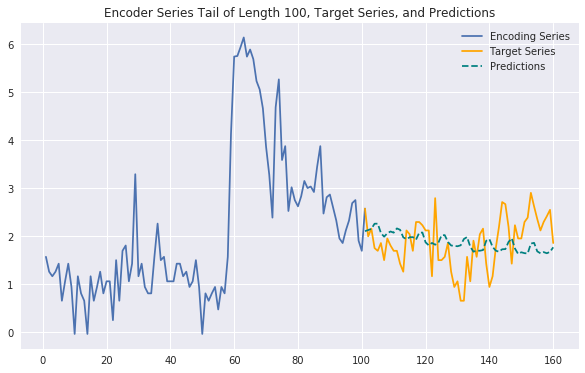

In [40]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=4000, enc_tail_len=100)

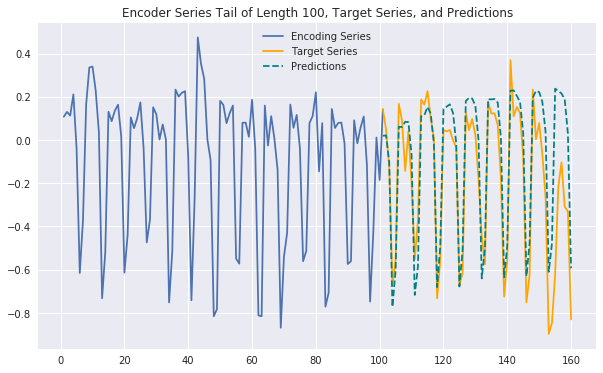

In [41]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=68000, enc_tail_len=100)

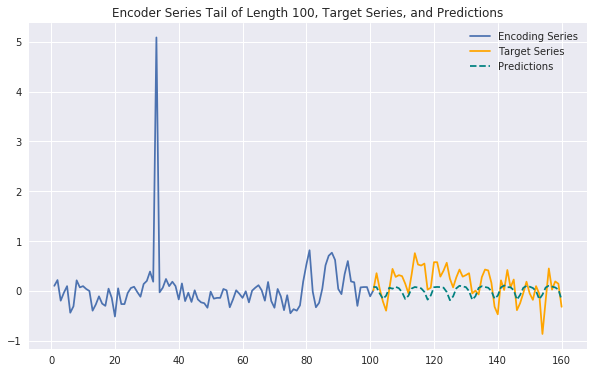

In [42]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=6007, enc_tail_len=100)

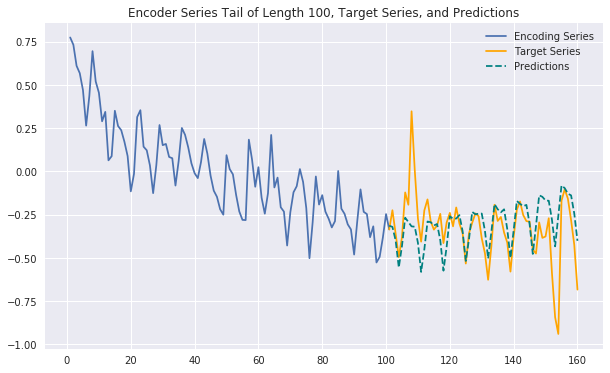

In [43]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=70450, enc_tail_len=100)

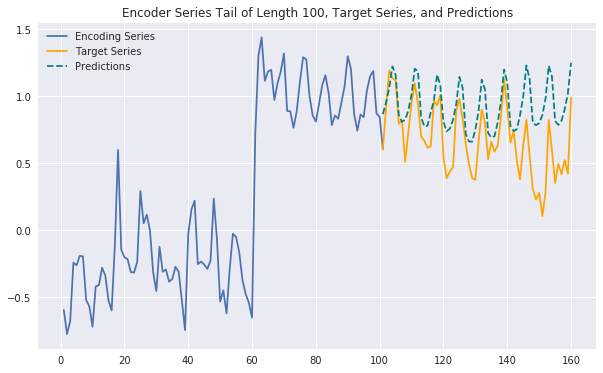

In [44]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=16551, enc_tail_len=100)